# Machine Translation + Transformer

In [1477]:
import math
import random
import time

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

# import torchdata
import torchtext

# device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device = "cpu"
print(f"{device}")

# make our work comparable if restarted the kernel
SEED = random.randrange(1, 10000)
print(f"{SEED=}")
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cpu
SEED=1527


In [1478]:
# !python -m spacy download en_core_web_sm
# !python -m spacy download de_core_news_sm

In [1479]:
# torch.cuda.get_device_name(0)

In [1480]:
torch.__version__

'2.2.0'

In [1481]:
torchtext.__version__

'0.17.0'

## 1. ETL: Loading the dataset

In [1482]:
# from torchtext.datasets import Multi30k

# SRC_LANGUAGE = "en"
# TRG_LANGUAGE = "de"

# train = Multi30k(split=("train"), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))

In [1483]:
dataset_fraction = 0.5

In [1484]:
# Load SCB-MT-EN-TH-2020 dataset
SRC_LANGUAGE = "en"
TRG_LANGUAGE = "th"

import torchdata.datapipes as dp
from datasets import load_dataset


def load_scb_mt_dataset():
    """Load SCB-MT-EN-TH-2020 dataset from Hugging Face."""
    dataset = load_dataset("airesearch/scb_mt_enth_2020", "enth")
    train_data = dataset["train"].shuffle(seed=SEED).select(range(int(dataset_fraction * len(dataset["train"]))))
    val_data = dataset["validation"].shuffle(seed=SEED).select(range(int(dataset_fraction * len(dataset["validation"]))))
    test_data = dataset["test"].shuffle(seed=SEED).select(range(int(dataset_fraction * len(dataset["test"]))))
    return train_data, val_data, test_data


# Load dataset
train, val, test = load_scb_mt_dataset()


# Convert the dataset to an iterable format
class DatasetIterable:
    def __init__(self, dataset):
        self.dataset = dataset

    def __iter__(self):
        for item in self.dataset:
            yield item


# Create DataPipes for train, validation, and test sets
train_datapipe = dp.iter.IterableWrapper(DatasetIterable(train))
val_datapipe = dp.iter.IterableWrapper(DatasetIterable(val))
test_datapipe = dp.iter.IterableWrapper(DatasetIterable(test))

# Apply ShardingFilter
sharded_train_datapipe = dp.iter.ShardingFilter(train_datapipe)
sharded_val_datapipe = dp.iter.ShardingFilter(val_datapipe)
sharded_test_datapipe = dp.iter.ShardingFilter(test_datapipe)

# Set the number of workers and the current worker ID
num_workers = 4
worker_id = 0  # Change this for each worker

sharded_train_datapipe.apply_sharding(num_of_instances=num_workers, instance_id=worker_id)
sharded_val_datapipe.apply_sharding(num_of_instances=num_workers, instance_id=worker_id)
sharded_test_datapipe.apply_sharding(num_of_instances=num_workers, instance_id=worker_id)

# Example: Iterate over the sharded train data
# for data in sharded_train_datapipe:
# print(data)


train = sharded_train_datapipe
val = sharded_val_datapipe
test = sharded_test_datapipe


# Function to transform the dataset structure
def restructure_dataset(dataset):
    return [(item["translation"]["en"], item["translation"]["th"]) for item in dataset]


# Apply transformation
train = restructure_dataset(train)
val = restructure_dataset(val)
test = restructure_dataset(test)

next(iter(train))

('The heroine is too much like an alpha female.',
 'นางเอกดูเป็นผู้หญิงมากเกินไป')

In [ ]:
# so this is a datapipe object; very similar to pytorch dataset version 2 which is better
train

## 2. EDA - simple investigation

In [1486]:
# let's take a look at one example of train
sample = next(iter(train))
sample

('The heroine is too much like an alpha female.',
 'นางเอกดูเป็นผู้หญิงมากเกินไป')

In [1487]:
train_size = len(list(iter(train)))
train_size

100176

In [1488]:
# train, val, test = train.random_split(total_length=train_size, weights={"train": 0.7, "val": 0.2, "test": 0.1}, seed=999)

In [1489]:
train_size = len(list(iter(train)))
train_size

100176

In [1490]:
val_size = len(list(iter(val)))
val_size

12522

In [1491]:
test_size = len(list(iter(test)))
test_size

12522

In [1492]:
# View sample of train
sample = next(iter(train))
sample

('The heroine is too much like an alpha female.',
 'นางเอกดูเป็นผู้หญิงมากเกินไป')

## 3. Preprocessing 

### Tokenizing

In [1493]:
# %pip install spacy==3.7.6
# !python -m spacy download en_core_web_sm
# !python -m spacy download de_core_news_sm

In [1494]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [1495]:
from torchtext.data.utils import get_tokenizer

token_transform[SRC_LANGUAGE] = get_tokenizer("spacy", language="en_core_web_sm")

from pythainlp.tokenize import word_tokenize

# token_transform[TRG_LANGUAGE] = get_tokenizer("spacy", language="de_core_news_sm")
token_transform[TRG_LANGUAGE] = lambda x: word_tokenize(x, engine="newmm")

In [1496]:
# example of tokenization of the english part
print("Sentence: ", sample[0])
print("Tokenization: ", token_transform[SRC_LANGUAGE](sample[0]))
print("Sentence: ", sample[1])
print("Tokenization: ", token_transform[TRG_LANGUAGE](sample[1]))

Sentence:  The heroine is too much like an alpha female.
Tokenization:  ['The', 'heroine', 'is', 'too', 'much', 'like', 'an', 'alpha', 'female', '.']
Sentence:  นางเอกดูเป็นผู้หญิงมากเกินไป
Tokenization:  ['นางเอก', 'ดู', 'เป็น', 'ผู้หญิง', 'มากเกินไป']


In [1497]:
# Find the maximum length of the source and target sentences
max_length = 0
for src, trg in train:
    max_length = max(max_length, max(len(token_transform[SRC_LANGUAGE](src)), len(token_transform[TRG_LANGUAGE](trg))))
max_length

534

A function to tokenize our input.

In [1498]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]])  # either first or second index

In [1499]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ["<unk>", "<pad>", "<sos>", "<eos>"]

### Text to integers (Numericalization)

In [1500]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(
        yield_tokens(train, ln),
        min_freq=2,  # if not, everything will be treated as UNK
        specials=special_symbols,
        special_first=True,
    )  # indicates whether to insert symbols at the beginning or at the end
# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [1501]:
# see some example
vocab_transform[SRC_LANGUAGE](["here", "is", "a", "unknownword", "a"])

[367, 19, 11, 0, 11]

In [1502]:
text = "If an unknown word appears, it should be mapped to <unk> instead of an out-of-range index."
print("Tokenized sentence:", token_transform[SRC_LANGUAGE](text))
print("Numericalized indices:", vocab_transform[SRC_LANGUAGE](token_transform[SRC_LANGUAGE](text)))

Tokenized sentence: ['If', 'an', 'unknown', 'word', 'appears', ',', 'it', 'should', 'be', 'mapped', 'to', '<', 'unk', '>', 'instead', 'of', 'an', 'out', '-', 'of', '-', 'range', 'index', '.']
Numericalized indices: [168, 44, 7194, 2375, 1816, 6, 14, 209, 23, 24055, 8, 4544, 0, 2723, 660, 9, 44, 90, 15, 9, 15, 522, 1451, 4]


In [1503]:
# we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

# print 1816, for example
# mapping[1816]

In [1504]:
# let's try unknown vocab
mapping[0]
# they will all map to <unk> which has 0 as integer

'<unk>'

In [1505]:
# let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [1506]:
# check unique vocabularies
len(mapping)

41385

## 4. Preparing the dataloader

In [1507]:
batch_size = 16

In [1508]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

# BATCH_SIZE = 64


# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input

    return func


# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), torch.tensor(token_ids), torch.tensor([EOS_IDX])))


# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(
        token_transform[ln],  # Tokenization
        vocab_transform[ln],  # Numericalization
        tensor_transform,
    )  # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []

    for src_sample, trg_sample in batch:
        # Tokenize and convert to tensor
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        processed_target = text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n"))

        src_batch.append(processed_text)
        # trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        trg_batch.append(processed_target)  # Add <sos> and <eos>

        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first=True)  # <----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first=True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

In [1509]:
# Function to remove problematic batch from train
def pop_batch(train, batch):
    for _ in range(batch_size):
        train.pop(batch)
    return train


# train = pop_batch(train, batch=248)

len(train)

100176

In [1510]:
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_batch, drop_last=True, num_workers=0)
valid_loader = DataLoader(val, batch_size=batch_size, shuffle=False, collate_fn=collate_batch, drop_last=True, num_workers=0)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, collate_fn=collate_batch, drop_last=True, num_workers=0)

In [1511]:
for en, _, th in train_loader:
    break

In [1512]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("Thai shape: ", th.shape)  # (batch_size, seq len)

English shape:  torch.Size([16, 99])
Thai shape:  torch.Size([16, 135])


## 5. Design the model

### Encoder Layer

In [1513]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, attention_type, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, attention_type, device)
        self.feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        # src = [batch size, src len, hid dim]
        # src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        # src: [batch_size, src len, hid dim]

        _src = self.feedforward(src)
        src = self.ff_layer_norm(src + self.dropout(_src))
        # src: [batch_size, src len, hid dim]

        return src

### Encoder

In [1514]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, attention_type, device, max_length=640):
        assert attention_type in ["gen", "mult", "add"], "Attention type must be either 'gen', 'mult' or 'add'."

        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)

        # self.pos_embedding = nn.Embedding(max_length, hid_dim)  # # Allow extra room

        # Currently, max_length=100 is hardcoded in self.pos_embedding. If src_len exceeds this value, an index out of range error occurs.
        self.max_length = max_length  # Store max length
        self.pos_embedding = nn.Embedding(max_length, hid_dim)  # # Allow extra room

        self.layers = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, attention_type, device) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)

    def forward(self, src, src_mask):
        # src = [batch size, src len]
        # src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        # pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)

        # Ensure Position Indices Are in Range
        pos = torch.arange(0, min(src_len, self.max_length)).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos: [batch_size, src_len]

        # If pos.max() >= self.pos_embedding.num_embeddings, it will cause an error.
        print(
            f"    Maximum 'pos' index: {pos.max()} of {self.pos_embedding.num_embeddings} | Maximum 'src' index: {src.max()} of {self.tok_embedding.num_embeddings}"
        )

        # print("  batch_size: ", batch_size, "src_len: ", src_len, "hid_dim: ", self.tok_embedding.embedding_dim)
        # print(f"  src shape: {src.shape}")
        # print(f"  src sample indices: {src}")
        # print(f"    Maximum 'src' index: {src.max()} of {self.tok_embedding.num_embeddings}")

        # Ensure all indices are within valid range
        # src = torch.clamp(src, max=self.tok_embedding.num_embeddings - 1)

        # Ensure all indices are within valid range, and check for negative indices (which are invalid).
        src = torch.clamp(src, min=0, max=self.tok_embedding.num_embeddings - 1)

        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        # src: [batch_size, src_len, hid_dim]

        for layer in self.layers:
            src = layer(src, src_mask)
        # src: [batch_size, src_len, hid_dim]

        # print(f"  Positional embedding max index: {pos.max()} of {self.pos_embedding.num_embeddings}")
        # print(f"  Token embedding max index: {src.max()} of {self.tok_embedding.num_embeddings}")

        return src

### Mutli Head Attention Layer

In [1515]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, attention_type, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

        self.attention_type = attention_type
        # Parameters for Multiplicative Attention
        if attention_type == "mult":
            self.W = nn.Parameter(torch.randn(self.head_dim, self.head_dim))  # Learnable weight matrix W

        # Parameters for Additive Attention
        if attention_type == "add":
            self.W1 = nn.Linear(self.head_dim, self.head_dim)
            self.W2 = nn.Linear(self.head_dim, self.head_dim)
            self.v = nn.Linear(self.head_dim, 1)

    def forward(self, query, key, value, mask=None):
        # src, src, src, src_mask
        # query = [batch size, query len, hid dim]
        # key = [batch size, key len, hid dim]
        # value = [batch size, value len, hid dim]

        batch_size = query.shape[0]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        # Q=K=V: [batch_size, src len, hid_dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        # Q = [batch_size, n heads, query len, head_dim]

        # energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        # Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        # energy = [batch_size, n heads, query len, key len]

        if self.attention_type == "gen":
            # general attention using dot product
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        elif self.attention_type == "mult":
            # multiplicative attention
            # introduce weighted matrix W before dot product
            energy = torch.matmul(torch.matmul(Q, self.W), K.permute(0, 1, 3, 2)) / self.scale
        elif self.attention_type == "add":
            # Additive Attention computation
            W1_K = self.W1(K)  # Shape: [batch_size, n_heads, key_len, head_dim]
            W2_Q = self.W2(Q)  # Shape: [batch_size, n_heads, query_len, head_dim]

            W2_Q_expanded = W2_Q.unsqueeze(3).expand(-1, -1, -1, K.shape[2], -1)

            # Compute energy using learned vector v
            energy = self.v(torch.tanh(W1_K.unsqueeze(2) + W2_Q_expanded)).squeeze(-1) / self.scale
            # Final Shape: [batch_size, n_heads, query_len, key_len]

            # Ensure alignment before matrix multiplication
            if V.shape[2] != energy.shape[-1]:  # energy.shape[-1] == key_len
                V = V[:, :, : energy.shape[-1], :]  # Ensure value_len == key_len

        # for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim=-1)
        # attention = [batch_size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attention), V)
        # [batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        # x = [batch_size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()  # we can perform .view
        # x = [batch_size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hid_dim)
        # x = [batch_size, query len, hid dim]

        x = self.fc_o(x)
        # x = [batch_size, query len, hid dim]

        return x, attention

### Position-wise Feedforward Layer

In [1516]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

### Decoder Layer

In [1517]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, attention_type, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, attention_type, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, attention_type, device)
        self.feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg = [batch size, trg len, hid dim]
        # enc_src = [batch size, src len, hid dim]
        # trg_mask = [batch size, 1, trg len, trg len]
        # src_mask = [batch size, 1, 1, src len]

        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
        # trg = [batch_size, trg len, hid dim]

        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        # trg = [batch_size, trg len, hid dim]
        # attention = [batch_size, n heads, trg len, src len]

        _trg = self.feedforward(trg)
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        # trg = [batch_size, trg len, hid dim]

        return trg, attention

### Decoder

In [1518]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, attention_type, device, max_length=640):
        assert attention_type in ["gen", "mult", "add"], "Attention type must be either 'gen', 'mult' or 'add'."

        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.max_length = max_length  # Store max length
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, attention_type, device) for _ in range(n_layers)])
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):
        # trg = [batch size, trg len]
        # enc_src = [batch size, src len, hid dim]
        # trg_mask = [batch size, 1, trg len, trg len]
        # src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        # pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        pos = torch.arange(0, min(trg_len, self.max_length)).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos: [batch_size, trg len]

        trg = torch.clamp(trg, min=0, max=self.tok_embedding.num_embeddings - 1)

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        # trg: [batch_size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        # trg: [batch_size, trg len, hid dim]
        # attention: [batch_size, n heads, trg len, src len]

        output = self.fc_out(trg)
        # output = [batch_size, trg len, output_dim]

        return output, attention

### Putting them together (become Seq2Seq!)

In [1519]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):
        # src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):
        # trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        # trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()
        # trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask
        # trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):
        # src = [batch size, src len]
        # trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        # src_mask = [batch size, 1, 1, src len]
        # trg_mask = [batch size, 1, trg len, trg len]

        print(
            f"    src_mask shape: got ({src_mask.shape[0]}, {src_mask.shape[1]}, {src_mask.shape[2]}, {src_mask.shape[3]}), expected {(batch_size, 1, 1, src.shape[1])} | trg_mask shape: got ({trg_mask.shape[0]}, {trg_mask.shape[1]}, {trg_mask.shape[2]}, {trg_mask.shape[3]}), expected {(batch_size, 1, trg.shape[1], trg.shape[1])}"
        )
        # print(
        #     f"    trg_mask shape: got ({trg_mask.shape[0]}, {trg_mask.shape[1]}, {trg_mask.shape[2]}, {trg_mask.shape[3]}), expected {(batch_size, 1, trg.shape[1], trg.shape[1])}"
        # )
        # assert src_mask.shape == (BATCH_SIZE, 1, 1, src.shape[1]), (
        #     f"Expected src_mask shape {(BATCH_SIZE, 1, 1, src.shape[1])}, but got {src_mask.shape}"
        # )
        # assert trg_mask.shape == (BATCH_SIZE, 1, trg.shape[1], trg.shape[1]), (
        #     f"Expected trg_mask shape {(BATCH_SIZE, 1, trg.shape[1], trg.shape[1])}, but got {trg_mask.shape}"
        # )

        enc_src = self.encoder(src, src_mask)
        # enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        # output = [batch size, trg len, output dim]
        # attention = [batch size, n heads, trg len, src len]

        return output, attention


## 6. Training

In [1520]:
def initialize_weights(m):
    if hasattr(m, "weight") and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [1521]:
# INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
# OUTPUT_DIM = len(vocab_transform[TRG_LANGUAGE])
# HID_DIM = 256
# ENC_LAYERS = 3
# DEC_LAYERS = 3
# ENC_HEADS = 8
# DEC_HEADS = 8
# ENC_PF_DIM = 512
# DEC_PF_DIM = 512
# ENC_DROPOUT = 0.1
# DEC_DROPOUT = 0.1

# enc = Encoder(INPUT_DIM, HID_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)

# dec = Decoder(OUTPUT_DIM, HID_DIM, DEC_LAYERS, DEC_HEADS, DEC_PF_DIM, DEC_DROPOUT, device)

# SRC_PAD_IDX = PAD_IDX
# TRG_PAD_IDX = PAD_IDX

In [1522]:
input_dim = len(vocab_transform[SRC_LANGUAGE])
output_dim = len(vocab_transform[TRG_LANGUAGE])
hid_dim = 256  # hidden dimension
enc_layers = 3
dec_layers = 3
enc_heads = 8
dec_heads = 8
enc_pf_dim = 512  # feedforward layer
dec_pf_dim = 512  # feedforward layer
enc_dropout = 0.1
dec_dropout = 0.1

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

# attention_type = ["gen", "mult", "add"]
# attention_type = "add"

enc_gen = Encoder(input_dim, hid_dim, enc_layers, enc_heads, enc_pf_dim, enc_dropout, attention_type="gen", device="cpu")
dec_gen = Decoder(output_dim, hid_dim, dec_layers, dec_heads, dec_pf_dim, enc_dropout, attention_type="gen", device="cpu")
model_gen = Seq2SeqTransformer(enc_gen, dec_gen, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_gen.apply(initialize_weights)

enc_mult = Encoder(input_dim, hid_dim, enc_layers, enc_heads, enc_pf_dim, enc_dropout, attention_type="mult", device="cpu")
dec_mult = Decoder(output_dim, hid_dim, dec_layers, dec_heads, dec_pf_dim, enc_dropout, attention_type="mult", device="cpu")
model_mult = Seq2SeqTransformer(enc_mult, dec_mult, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_mult.apply(initialize_weights)

enc_add = Encoder(input_dim, hid_dim, enc_layers, enc_heads, enc_pf_dim, enc_dropout, attention_type="add", device="cpu")
dec_add = Decoder(output_dim, hid_dim, dec_layers, dec_heads, dec_pf_dim, enc_dropout, attention_type="add", device="cpu")
model_add = Seq2SeqTransformer(enc_add, dec_add, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_add.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(41385, 256)
    (pos_embedding): Embedding(640, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (W1): Linear(in_features=32, out_features=32, bias=True)
          (W2): Linear(in_features=32, out_features=32, bias=True)
          (v): Linear(in_features=32, out_features=1, bias=True)
        )
        (feedforward): PositionwiseFeedforwardLayer(
    

In [1523]:
# we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f"{item:>10}")
    print(f"________\n{sum(params):>6}")


# count_parameters(model)

In [1524]:
import torch.optim as optim

lr = 0.0005

# training hyperparameters
optimizer_gen = optim.Adam(model_gen.parameters(), lr=lr)
optimizer_mult = optim.Adam(model_mult.parameters(), lr=lr)
optimizer_add = optim.Adam(model_add.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)  # combine softmax with cross entropy

In [1525]:
# Training function

import signal

from tqdm import tqdm


def timeout_handler(signum, frame):
    raise TimeoutError("Batch processing took too long!")


signal.signal(signal.SIGALRM, timeout_handler)


scaler = torch.cuda.amp.GradScaler()


def train(model, loader, optimizer, criterion, clip, loader_length):
    model.train()

    epoch_loss = 0
    batch_loss = []

    # progress_bar = tqdm(loader, total=loader_length, desc="Training...")

    # for src, src_len, trg in tqdm(loader, total=loader_length, desc="Training..."):
    for batch_idx, (src, src_len, trg) in enumerate(loader):
        signal.alarm(30)  # Set a 30-second timeout
        try:
            print(f"  Training Batch: {batch_idx + 1} / {loader_length}")

            # if batch_idx == 249:
            #     print("      Skip batch 249")
            #     continue

            src = src.to(device)
            trg = trg.to(device)

            optimizer.zero_grad()

            # with torch.cuda.amp.autocast():
            #     output, _ = model(src, trg[:, :-1])

            #     # output = [batch size, trg len - 1, output dim]
            #     # trg    = [batch size, trg len]

            #     output_dim = output.shape[-1]

            #     output = output.reshape(-1, output_dim)
            #     trg = trg[:, 1:].reshape(
            #         -1
            #     )  # trg[:, 1:] remove sthe sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos

            #     # output = [batch size * trg len - 1, output dim]
            #     # trg    = [batch size * trg len - 1]

            #     loss = criterion(output, trg)

            # scaler.scale(loss).backward()
            # scaler.step(optimizer)
            # scaler.update()

            # trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
            output, _ = model(src, trg[:, :-1])

            # output = [batch size, trg len - 1, output dim]
            # trg    = [batch size, trg len]

            # print("  -- Output shape: ", output.shape, "Trg shape: ", trg.shape)

            output_dim = output.shape[-1]

            output = output.reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(
                -1
            )  # trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos

            # output = [batch size * trg len - 1, output dim]
            # trg    = [batch size * trg len - 1]

            # print("  ---- Output shape: ", output.shape, "Trg shape: ", trg.shape)

            loss = criterion(output, trg)

            print(f"    Loss: {loss.item()}")

            for name, param in model.named_parameters():
                if param.grad is not None:
                    print(f"    {name}: Grad Norm = {param.grad.norm().item()}")

            backward_start = time.time()
            loss.backward()
            print(f"    Backward Time: {time.time() - backward_start:.3f} sec")

            clip_start = time.time()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            print(f"    Clip Time: {time.time() - clip_start:.3f} sec")

            step_start = time.time()
            optimizer.step()
            print(f"    Step Time: {time.time() - step_start:.3f} sec")

            epoch_loss += loss.item()
            batch_loss.append(loss.item())

        except TimeoutError as e:
            print(f"Batch {batch_idx + 1} took too long! Skipping...")
            # progress_bar.update(1)
            continue
        finally:
            signal.alarm(0)  # Disable the alarm

    return epoch_loss / loader_length, batch_loss

/Users/silanm/Developer/nlp-a3-machine-translation/.venv/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:126: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [1526]:
# Evaluation function


def evaluate(model, loader, criterion, loader_length):
    model.eval()

    epoch_loss = 0
    batch_loss = []

    with torch.no_grad():
        for batch_idx, (src, src_len, trg) in enumerate(loader):
            print(f"  Evaluating Batch: {batch_idx + 1} / {loader_length}")

            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:, :-1])

            # output = [batch size, trg len - 1, output dim]
            # trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:, 1:].contiguous().view(-1)

            # output = [batch size * trg len - 1, output dim]
            # trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            print(f"    Loss: {loss.item()}")

            epoch_loss += loss.item()
            batch_loss.append(loss.item())

    return epoch_loss / loader_length, batch_loss

In [1527]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length = len(list(iter(valid_loader)))
test_loader_length = len(list(iter(test_loader)))

train_loader_length, val_loader_length, test_loader_length

(6261, 782, 782)

In [1528]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
from datetime import datetime

genatt_best_valid_loss = float("inf")
multatt_best_valid_loss = float("inf")
addatt_best_valid_loss = float("inf")

num_epochs = 1
clip = 1

timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
genatt_save_path = f"models/{timestamp}_{model_gen.__class__.__name__}_genatt_seed{SEED}_nb{train_loader_length}_bs{batch_size}.pt"
multatt_save_path = f"models/{timestamp}_{model_mult.__class__.__name__}_multatt_seed{SEED}_nb{train_loader_length}_bs{batch_size}.pt"
addatt_save_path = f"models/{timestamp}_{model_mult.__class__.__name__}_addatt_seed{SEED}_nb{train_loader_length}_bs{batch_size}.pt"

genatt_train_all_epoch_losses = []
genatt_valid_all_epoch_losses = []
multatt_train_all_epoch_losses = []
multatt_valid_all_epoch_losses = []
addatt_train_all_epoch_losses = []
addatt_valid_all_epoch_losses = []

torch.cuda.empty_cache()

print("Training started...")

for epoch in range(num_epochs):
    epoch_start_time = time.time()

    print(f"\nEpoch: {epoch + 1:02} | General Attention | Training...")
    genatt_train_start_time = time.time()
    genatt_train_avg_loss, genatt_train_batch_loss = train(model_gen, train_loader, optimizer_gen, criterion, clip, train_loader_length)
    genatt_train_end_time = time.time()
    print(f"\nEpoch: {epoch + 1:02} | General Attention | Evaluating...")
    genatt_valid_start_time = time.time()
    genatt_valid_avg_loss, genatt_valid_batch_loss = evaluate(model_gen, valid_loader, criterion, val_loader_length)
    genatt_valid_end_time = time.time()

    print(f"\nEpoch: {epoch + 1:02} | Multiplicative Attention | Training...")
    multatt_train_start_time = time.time()
    multatt_train_avg_loss, multatt_train_batch_loss = train(model_mult, train_loader, optimizer_mult, criterion, clip, train_loader_length)
    multatt_train_end_time = time.time()
    print(f"\nEpoch: {epoch + 1:02} | Multiplicative Attention | Evaluating...")
    multatt_valid_start_time = time.time()
    multatt_valid_avg_loss, multatt_valid_batch_loss = evaluate(model_mult, valid_loader, criterion, val_loader_length)
    multatt_valid_end_time = time.time()

    print(f"\nEpoch: {epoch + 1:02} | Additive Attention | Training...")
    addatt_train_start_time = time.time()
    addatt_train_avg_loss, addatt_train_batch_loss = train(model_add, train_loader, optimizer_add, criterion, clip, train_loader_length)
    addatt_train_end_time = time.time()
    print(f"\nEpoch: {epoch + 1:02} | Additive Attention | Evaluating...")
    addatt_valid_start_time = time.time()
    addatt_valid_avg_loss, addatt_valid_batch_loss = evaluate(model_add, valid_loader, criterion, val_loader_length)
    addatt_valid_end_time = time.time()

    # for plotting
    genatt_train_all_epoch_losses.append(genatt_train_avg_loss)
    genatt_valid_all_epoch_losses.append(genatt_valid_avg_loss)
    multatt_train_all_epoch_losses.append(multatt_train_avg_loss)
    multatt_valid_all_epoch_losses.append(multatt_valid_avg_loss)
    addatt_train_all_epoch_losses.append(addatt_train_avg_loss)
    addatt_valid_all_epoch_losses.append(addatt_valid_avg_loss)

    epoch_end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(epoch_start_time, epoch_end_time)
    genatt_train_mins, genatt_train_secs = epoch_time(genatt_train_start_time, genatt_train_end_time)
    genatt_valid_mins, genatt_valid_secs = epoch_time(genatt_valid_start_time, genatt_valid_end_time)
    multatt_train_mins, multatt_train_secs = epoch_time(multatt_train_start_time, multatt_train_end_time)
    multatt_valid_mins, multatt_valid_secs = epoch_time(multatt_valid_start_time, multatt_valid_end_time)
    addatt_train_mins, addatt_train_secs = epoch_time(addatt_train_start_time, addatt_train_end_time)
    addatt_valid_mins, addatt_valid_secs = epoch_time(addatt_valid_start_time, addatt_valid_end_time)

    if genatt_valid_avg_loss < genatt_best_valid_loss:
        genatt_best_valid_loss = genatt_valid_avg_loss
        torch.save(model_gen.state_dict(), genatt_save_path)
        print(f"\nModel saved to `models/{genatt_save_path}`")

    if multatt_valid_avg_loss < multatt_best_valid_loss:
        multatt_best_valid_loss = multatt_valid_avg_loss
        torch.save(model_mult.state_dict(), multatt_save_path)
        print(f"Model saved to `models/{multatt_save_path}`")

    if addatt_valid_avg_loss < addatt_best_valid_loss:
        addatt_best_valid_loss = addatt_valid_avg_loss
        torch.save(model_add.state_dict(), addatt_save_path)
        print(f"Model saved to `models/{addatt_save_path}`")

    print(f"\nEpoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s")
    print("  General Attention")
    print(
        f"    Train Loss: {genatt_train_avg_loss:.3f} | Train Perplexity: {math.exp(genatt_train_avg_loss):7.3f} | Time: {genatt_train_mins}m {genatt_train_secs}s"
    )
    print(
        f"    Val. Loss: {genatt_valid_avg_loss:.3f} |  Val. Perplexity: {math.exp(genatt_valid_avg_loss):7.3f} | Time: {genatt_valid_mins}m {genatt_valid_secs}s"
    )
    print("  Multiplicative Attention")
    print(
        f"    Train Loss: {multatt_train_avg_loss:.3f} | Train Perplexity: {math.exp(multatt_train_avg_loss):7.3f} | Time: {multatt_train_mins}m {multatt_train_secs}s"
    )
    print(
        f"    Val. Loss: {multatt_valid_avg_loss:.3f} |  Val. Perplexity: {math.exp(multatt_valid_avg_loss):7.3f} | Time: {multatt_valid_mins}m {multatt_valid_secs}s"
    )
    print("  Additive Attention")
    print(
        f"    Train Loss: {addatt_train_avg_loss:.3f} | Train Perplexity: {math.exp(addatt_train_avg_loss):7.3f} | Time: {addatt_train_mins}m {addatt_train_secs}s"
    )
    print(
        f"    Val. Loss: {addatt_valid_avg_loss:.3f} |  Val. Perplexity: {math.exp(addatt_valid_avg_loss):7.3f} | Time: {addatt_valid_mins}m {addatt_valid_secs}s"
    )

    # Plot loss from this epoch (all batches), use subplots (1 row, 2 columns)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=300)

    # Plot loss
    axs[0].plot(genatt_train_batch_loss, label="General Attention", color="blue")
    axs[0].plot(multatt_train_batch_loss, label="Multiplicative Attention", color="green", linestyle="--")
    axs[0].plot(addatt_train_batch_loss, label="Additive Attention", color="red", linestyle="-.")
    axs[0].set_title("Training Loss")
    axs[0].set_xlabel("Batch")
    axs[0].set_ylabel("Loss")
    axs[0].legend(loc="upper right")

    axs[1].plot(genatt_valid_batch_loss, label="General Attention", color="blue")
    axs[1].plot(multatt_valid_batch_loss, label="Multiplicative Attention", color="green", linestyle="--")
    axs[1].plot(addatt_valid_batch_loss, label="Additive Attention", color="red", linestyle="-.")
    axs[1].set_title("Validation Loss")
    axs[1].set_xlabel("Batch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")

    plt.tight_layout()
    plt.show()

    # lower perplexity is better

print("\n\nTraining completed...")
print("\nConfigurations")
print(f"  Device: {device}")
print(f"  Seed: {SEED}")
print(f"  Batch size: {batch_size}")
print(f"  Train size: {train_size}")
print(f"  Val size: {val_size}")
print(f"  Test size: {test_size}")
print(f"  Train loader length: {train_loader_length}")
print(f"  Val loader length: {val_loader_length}")
print(f"  Test loader length: {test_loader_length}")
print(f"  [General Attention] Best validation loss: {genatt_best_valid_loss}")
print(f"  [Multiplicative Attention] Best validation loss: {multatt_best_valid_loss}")
print(f"  [Additive Attention] Best validation loss: {addatt_best_valid_loss}")

In [1530]:
# Skip plotting because only 1 epoch

# fig = plt.figure(figsize=(5, 3))
# ax = fig.add_subplot(1, 1, 1)
# ax.plot(train_losses, label="train loss")
# ax.plot(valid_losses, label="valid loss")
# plt.legend()
# ax.set_xlabel("updates")
# ax.set_ylabel("loss")

In [ ]:
model_gen_test = Seq2SeqTransformer(enc_gen, dec_gen, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_gen_test.load_state_dict(torch.load(genatt_save_path))
test_loss, genatt_test_batch_loss = evaluate(model_gen_test, test_loader, criterion, test_loader_length)
print(f"General Attention | Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |")

model_mult_test = Seq2SeqTransformer(enc_mult, dec_mult, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_mult_test.load_state_dict(torch.load(multatt_save_path))
test_loss, multatt_test_batch_loss = evaluate(model_mult_test, test_loader, criterion, test_loader_length)
print(f"Multiplicative Attention | Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |")

model_add_test = Seq2SeqTransformer(enc_add, dec_add, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model_add_test.load_state_dict(torch.load(addatt_save_path))
test_loss, addatt_test_batch_loss = evaluate(model_add_test, test_loader, criterion, test_loader_length)
print(f"Additive Attention | Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |")

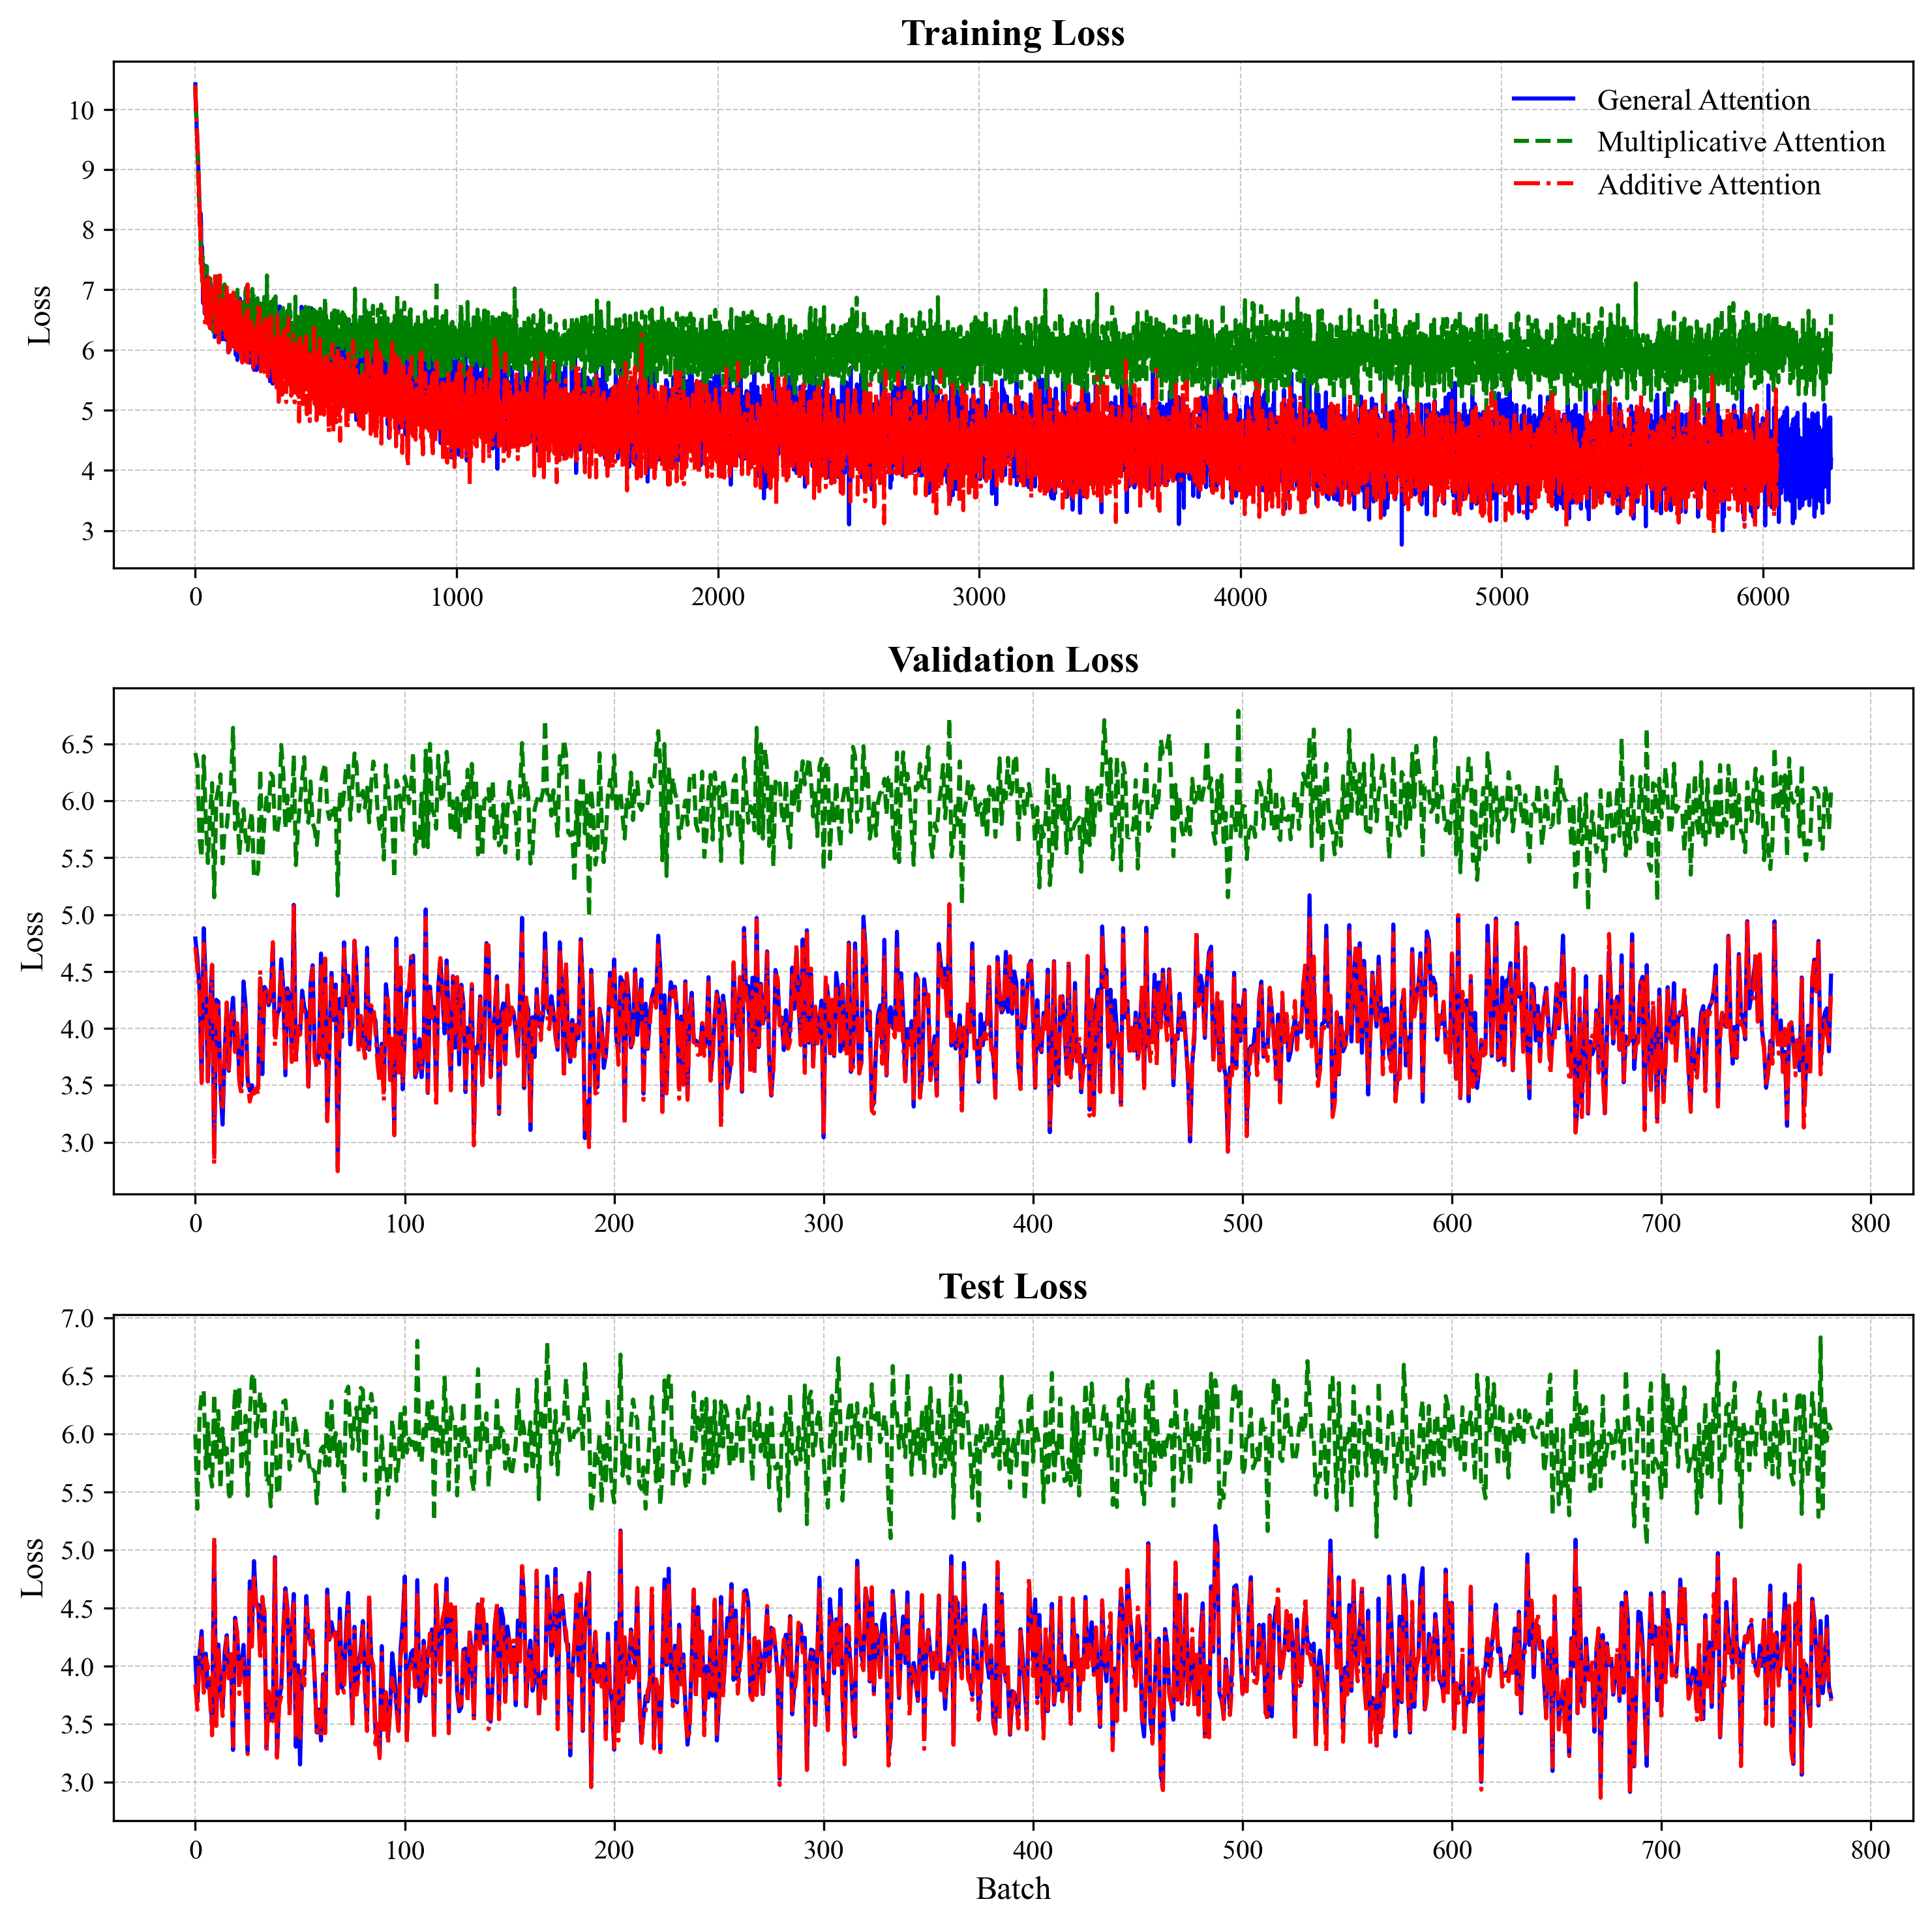

In [1532]:
plt.rcParams["font.family"] = "Times New Roman"  # Change font
plt.rcParams["font.size"] = 12  # Adjust text size
plt.rcParams["axes.titlesize"] = 14  # Title size
plt.rcParams["axes.titleweight"] = "bold"  # Title weight
plt.rcParams["axes.labelsize"] = 12  # X, Y label size
plt.rcParams["legend.fontsize"] = 11  # Legend size
plt.rcParams["xtick.labelsize"] = 10  # X-axis tick label size
plt.rcParams["ytick.labelsize"] = 10  # Y-axis tick label size

# Plot loss from this epoch (all batches), use subplots (1 row, 2 columns)
fig, axs = plt.subplots(3, 1, figsize=(10, 10), dpi=300)

# Plot loss
axs[0].plot(genatt_train_batch_loss, label="General Attention", color="blue")
axs[0].plot(multatt_train_batch_loss, label="Multiplicative Attention", color="green", linestyle="--")
axs[0].plot(addatt_train_batch_loss, label="Additive Attention", color="red", linestyle="-.")
axs[0].set_title("Training Loss")
# axs[0].set_xlabel("Batch")
axs[0].set_ylabel("Loss")
axs[0].legend(loc="upper right", frameon=False)
axs[0].grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

axs[1].plot(genatt_valid_batch_loss, label="General Attention", color="blue")
axs[1].plot(multatt_valid_batch_loss, label="Multiplicative Attention", color="green", linestyle="--")
axs[1].plot(addatt_valid_batch_loss, label="Additive Attention", color="red", linestyle="-.")
axs[1].set_title("Validation Loss")
# axs[1].set_xlabel("Batch")
axs[1].set_ylabel("Loss")
# axs[1].legend(loc="upper right", frameon=False)
axs[1].grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

axs[2].plot(genatt_test_batch_loss, label="General Attention", color="blue")
axs[2].plot(multatt_test_batch_loss, label="Multiplicative Attention", color="green", linestyle="--")
axs[2].plot(addatt_test_batch_loss, label="Additive Attention", color="red", linestyle="-.")
axs[2].set_title("Test Loss")
axs[2].set_xlabel("Batch")
axs[2].set_ylabel("Loss")
# axs[2].legend(loc="upper right", frameon=False)
axs[2].grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()
fig.savefig(
    f"all_losses_{timestamp}_seed{SEED}_nb{train_loader_length}_bs{batch_size}.svg",
    format="svg",
    bbox_inches="tight",
)  # Best for scaling

## 7. Test on some random news

In [1643]:
# sample = next(iter(test))
sample = random.choice(test)

In [1644]:
sample[0]

'Just like my other review, for some reason I thought it was going to be made of quality rubber.'

In [1645]:
sample[1]

'เช่นเดียวกับรีวิวอื่น ๆ ของฉันด้วยเหตุผลบางอย่างฉันคิดว่ามันจะทําจากยางที่มีคุณภาพ'

In [1646]:
src_text = text_transform[SRC_LANGUAGE](sample[0]).to(device)
src_text

tensor([   2,  380,   47,   51,   93, 1102,    6,   13,  109,  810,   17,  594,
          14,   34,  249,    8,   23,  126,    9,   68,  566,    4,    3])

In [1647]:
trg_text = text_transform[TRG_LANGUAGE](sample[1]).to(device)
trg_text

tensor([   2, 1289,  746,  132,    4,   44,    4,    6,   15,   26,  848,  703,
          15,  207,   29,   20,   18,   22,   16,  540,    5,   10,  123,    3])

In [1648]:
src_text = src_text.reshape(1, -1)  # because batch_size is 1

In [1649]:
trg_text = trg_text.reshape(1, -1)

In [1650]:
src_text.shape, trg_text.shape

(torch.Size([1, 23]), torch.Size([1, 24]))

In [1651]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [1652]:
model_gen_test.load_state_dict(torch.load(genatt_save_path))
model_mult_test.load_state_dict(torch.load(multatt_save_path))
model_add_test.load_state_dict(torch.load(addatt_save_path))

model_gen_test.eval()
model_mult_test.eval()
model_add_test.eval()

with torch.no_grad():
    output_genatt, attentions_genatt = model_gen_test(src_text, trg_text)  # turn off teacher forcing
    output_multatt, attentions_multatt = model_mult_test(src_text, trg_text)
    output_addatt, attentions_addatt = model_add_test(src_text, trg_text)

    src_mask shape: got (1, 1, 1, 23), expected (16, 1, 1, 23) | trg_mask shape: got (1, 1, 24, 24), expected (16, 1, 24, 24)
    Maximum 'pos' index: 22 of 640 | Maximum 'src' index: 1102 of 41385
    src_mask shape: got (1, 1, 1, 23), expected (16, 1, 1, 23) | trg_mask shape: got (1, 1, 24, 24), expected (16, 1, 24, 24)
    Maximum 'pos' index: 22 of 640 | Maximum 'src' index: 1102 of 41385
    src_mask shape: got (1, 1, 1, 23), expected (16, 1, 1, 23) | trg_mask shape: got (1, 1, 24, 24), expected (16, 1, 24, 24)
    Maximum 'pos' index: 22 of 640 | Maximum 'src' index: 1102 of 41385


In [1653]:
output_genatt.shape, output_multatt.shape, output_addatt.shape  # batch_size, trg_len, trg_output_dim

(torch.Size([1, 24, 32531]),
 torch.Size([1, 24, 32531]),
 torch.Size([1, 24, 32531]))

Since batch size is 1, we just take off that dimension

In [1654]:
output_genatt = output_genatt.squeeze(0)
output_multatt = output_multatt.squeeze(0)
output_addatt = output_addatt.squeeze(0)

In [1655]:
output_genatt.shape, output_multatt.shape, output_addatt.shape  # trg_len, trg_output_dim

(torch.Size([24, 32531]), torch.Size([24, 32531]), torch.Size([24, 32531]))

We shall remove the first token since it's zeroes anyway

In [1656]:
output_genatt = output_genatt[1:]
output_multatt = output_multatt[1:]
output_addatt = output_addatt[1:]

output_genatt.shape, output_multatt.shape, output_addatt.shape  # trg_len, trg_output_dim

(torch.Size([23, 32531]), torch.Size([23, 32531]), torch.Size([23, 32531]))

Then we just take the top token with highest probabilities

In [1657]:
output_genatt_max = output_genatt.argmax(1)  # returns max indices
output_multatt_max = output_multatt.argmax(1)  # returns max indices
output_addatt_max = output_addatt.argmax(1)  # returns max indices

In [1658]:
output_genatt_max, output_multatt_max, output_addatt_max

(tensor([107,  25,   4,  44,   4,   6,  15,   3,  43,   5,   5,   3,  29,  20,
          18,  12,  76,  68,   3,  15,  74, 115,   3]),
 tensor([15,  3,  4, 37,  3, 37,  3,  3,  3,  3, 37,  3,  3,  3,  3,  4,  3,  3,
          3, 15, 15,  3,  3]),
 tensor([107,  25,   4,  44,   4,   5,  15,  12,   4,   5,   5,  12,  29,  20,
          18,  12,  14,  20,   3,  15,   3,   3,   3]))

Get the mapping of the target language

In [1659]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [1660]:
translated_sentence_genatt = "".join([mapping[token.item()] for token in output_genatt_max if mapping[token.item()] != "<eos>"])
translated_sentence_multatt = "".join([mapping[token.item()] for token in output_multatt_max if mapping[token.item()] != "<eos>"])
translated_sentence_addatt = "".join([mapping[token.item()] for token in output_addatt_max if mapping[token.item()] != "<eos>"])

print(f"Source (EN):\t\t\t\t\t'{sample[0]}'")
print(f"Grouth truth (TH):\t\t\t\t'{sample[1]}'")
print(f"Predicted using General Attention (TH):\t\t'{translated_sentence_genatt}'")
print(f"Predicted using Multiplicative Attention (TH):\t'{translated_sentence_multatt}'")
print(f"Predicted using Additive Attention (TH):\t'{translated_sentence_addatt}'")

Source (EN):					'Just like my other review, for some reason I thought it was going to be made of quality rubber.'
Grouth truth (TH):				'เช่นเดียวกับรีวิวอื่น ๆ ของฉันด้วยเหตุผลบางอย่างฉันคิดว่ามันจะทําจากยางที่มีคุณภาพ'
Predicted using General Attention (TH):		'หนังสือนี้ ๆ ของฉันผลิตภัณฑ์ที่ที่ว่ามันจะไม่งานสิ่งฉันอะไรสูง'
Predicted using Multiplicative Attention (TH):	'ฉัน แต่แต่แต่ ฉันฉัน'
Predicted using Additive Attention (TH):	'หนังสือนี้ ๆ ที่ฉันไม่ ที่ที่ไม่ว่ามันจะไม่ให้มันฉัน'


## 8. Attention

Let's display the attentions to understand how the source text links with the generated text

In [1661]:
attentions_genatt.shape, attentions_multatt.shape, attentions_addatt.shape

(torch.Size([1, 8, 24, 23]),
 torch.Size([1, 8, 24, 23]),
 torch.Size([1, 8, 24, 23]))

Since there are 8 heads, we can look at just 1 head for sake of simplicity.

In [1662]:
# Ensure attentions_genatt and attentions_multatt have at least 3 dimensions before indexing
if attentions_genatt.dim() == 4:
    attentions_genatt = attentions_genatt[0, 0, :, :]

if attentions_multatt.dim() == 4:
    attentions_multatt = attentions_multatt[0, 0, :, :]

if attentions_addatt.dim() == 4:
    attentions_addatt = attentions_addatt[0, 0, :, :]

attentions_genatt.shape, attentions_multatt.shape, attentions_addatt.shape

(torch.Size([24, 23]), torch.Size([24, 23]), torch.Size([24, 23]))

In [1663]:
src_tokens = ["<sos>"] + token_transform[SRC_LANGUAGE](sample[0]) + ["<eos>"]
src_tokens

['<sos>',
 'Just',
 'like',
 'my',
 'other',
 'review',
 ',',
 'for',
 'some',
 'reason',
 'I',
 'thought',
 'it',
 'was',
 'going',
 'to',
 'be',
 'made',
 'of',
 'quality',
 'rubber',
 '.',
 '<eos>']

In [1664]:
trg_tokens_genatt = ["<sos>"] + [mapping[token.item()] for token in output_genatt_max]
trg_tokens_multatt = ["<sos>"] + [mapping[token.item()] for token in output_multatt_max]
trg_tokens_addatt = ["<sos>"] + [mapping[token.item()] for token in output_addatt_max]

trg_tokens_genatt, trg_tokens_multatt, trg_tokens_addatt

(['<sos>',
  'หนังสือ',
  'นี้',
  ' ',
  'ๆ',
  ' ',
  'ของ',
  'ฉัน',
  '<eos>',
  'ผลิตภัณฑ์',
  'ที่',
  'ที่',
  '<eos>',
  'ว่า',
  'มัน',
  'จะ',
  'ไม่',
  'งาน',
  'สิ่ง',
  '<eos>',
  'ฉัน',
  'อะไร',
  'สูง',
  '<eos>'],
 ['<sos>',
  'ฉัน',
  '<eos>',
  ' ',
  'แต่',
  '<eos>',
  'แต่',
  '<eos>',
  '<eos>',
  '<eos>',
  '<eos>',
  'แต่',
  '<eos>',
  '<eos>',
  '<eos>',
  '<eos>',
  ' ',
  '<eos>',
  '<eos>',
  '<eos>',
  'ฉัน',
  'ฉัน',
  '<eos>',
  '<eos>'],
 ['<sos>',
  'หนังสือ',
  'นี้',
  ' ',
  'ๆ',
  ' ',
  'ที่',
  'ฉัน',
  'ไม่',
  ' ',
  'ที่',
  'ที่',
  'ไม่',
  'ว่า',
  'มัน',
  'จะ',
  'ไม่',
  'ให้',
  'มัน',
  '<eos>',
  'ฉัน',
  '<eos>',
  '<eos>',
  '<eos>'])

# Attention Map

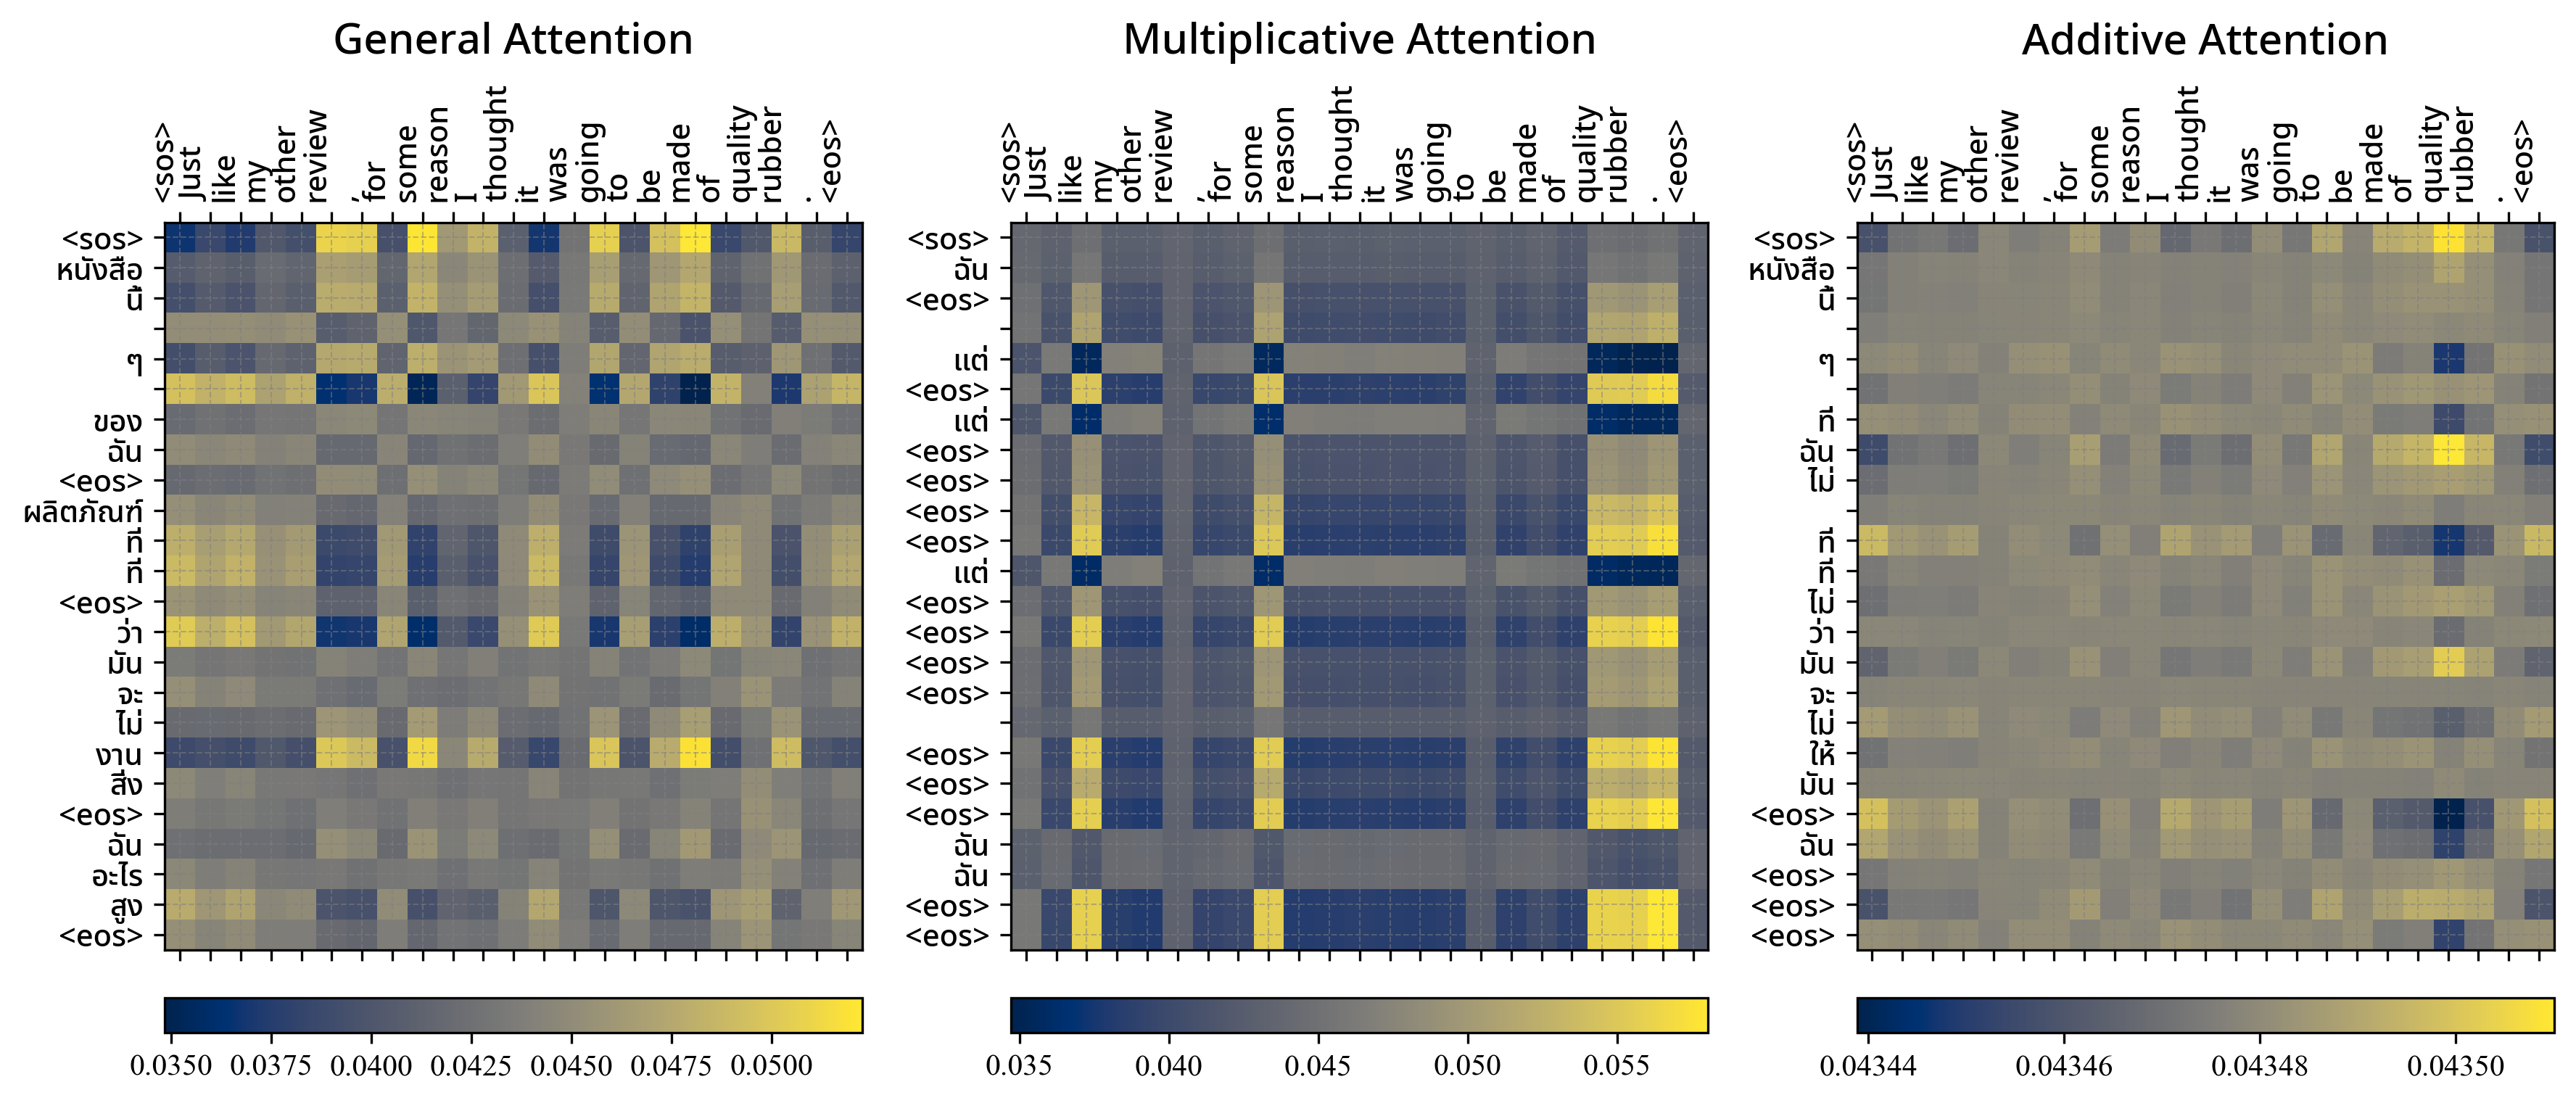

In [1666]:
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker

# Load a custom Thai font
font_path = "fonts/NotoSansThai-Medium.ttf"  # Change this to your downloaded font file
thai_font = fm.FontProperties(fname=font_path)

attentions_genatt_plot = attentions_genatt.squeeze(1).cpu().detach().numpy()
attentions_multatt_plot = attentions_multatt.squeeze(1).cpu().detach().numpy()
attentions_addatt_plot = attentions_addatt.squeeze(1).cpu().detach().numpy()

# Figure Setup (More balanced size)
fig, axes = plt.subplots(1, 3, figsize=(12, 6), dpi=300)

# --- General Attention Plot ---
cax1 = axes[0].matshow(attentions_genatt_plot, cmap="cividis")
axes[0].set_title("General Attention", fontproperties=thai_font, fontsize=14, pad=10)
axes[0].tick_params(labelsize=10)
axes[0].set_xticks(range(len(src_tokens)))
axes[0].set_xticklabels(src_tokens, rotation=90, ha="right", fontproperties=thai_font, fontsize=10)
axes[0].set_yticks(range(len(trg_tokens_genatt)))
axes[0].set_yticklabels(trg_tokens_genatt, fontproperties=thai_font, fontsize=10)
axes[0].grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.5)
fig.colorbar(cax1, ax=axes[0], orientation="horizontal", fraction=0.046, pad=0.04)

# --- Multiplicative Attention Plot ---
cax2 = axes[1].matshow(attentions_multatt_plot, cmap="cividis")
axes[1].set_title("Multiplicative Attention", fontproperties=thai_font, fontsize=14, pad=10)
axes[1].tick_params(labelsize=10)
axes[1].set_xticks(range(len(src_tokens)))
axes[1].set_xticklabels(src_tokens, rotation=90, ha="right", fontproperties=thai_font, fontsize=10)
axes[1].set_yticks(range(len(trg_tokens_multatt)))
axes[1].set_yticklabels(trg_tokens_multatt, fontproperties=thai_font, fontsize=10)
axes[1].grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.5)
fig.colorbar(cax2, ax=axes[1], orientation="horizontal", fraction=0.046, pad=0.04)

# --- Additive Attention Plot ---
cax3 = axes[2].matshow(attentions_addatt_plot, cmap="cividis")
axes[2].set_title("Additive Attention", fontproperties=thai_font, fontsize=14, pad=10)
axes[2].tick_params(labelsize=10)
axes[2].set_xticks(range(len(src_tokens)))
axes[2].set_xticklabels(src_tokens, rotation=90, ha="right", fontproperties=thai_font, fontsize=10)
axes[2].set_yticks(range(len(trg_tokens_addatt)))
axes[2].set_yticklabels(trg_tokens_addatt, fontproperties=thai_font, fontsize=10)
axes[2].grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.5)
fig.colorbar(cax3, ax=axes[2], orientation="horizontal", fraction=0.046, pad=0.04)


# Adjust layout
plt.tight_layout()
plt.show()
plt.close()
fig.savefig(
    f"attention_maps_{timestamp}_seed{SEED}_nb{train_loader_length}_bs{batch_size}.svg",
    format="svg",
    bbox_inches="tight",
)  # Best for scaling